# Single-Layer DNN Sequence Forecast

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0


In [3]:
# Some helper-functions for creating sequences with trnds, seasonality, and random noise

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [4]:
# Settings for creating sequences

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

In [5]:
# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

In [6]:
# Split sequence in train (all up to split time) and validation sets (all after split time)

split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

# training parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [8]:
# Helper Function: Training set windowing

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)

  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))

  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

In [9]:
# Execute helper Function: Training set windowing

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)

# Single dense NN layer
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

# Model hyperparameters and optimizer
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))

# Train model
model.fit(dataset,epochs=100,verbose=0)

print("Layer weights {}".format(l0.get_weights()))

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>
Layer weights [array([[-0.08948548],
       [ 0.03591289],
       [ 0.09370562],
       [-0.06039736],
       [ 0.02253656],
       [-0.00503281],
       [ 0.01479856],
       [-0.03873892],
       [ 0.00563281],
       [-0.01417149],
       [ 0.08719949],
       [-0.07869645],
       [ 0.03683625],
       [-0.08837202],
       [ 0.09981419],
       [ 0.05294093],
       [ 0.07361432],
       [ 0.1144168 ],
       [ 0.2608862 ],
       [ 0.46107513]], dtype=float32), array([0.01706426], dtype=float32)]


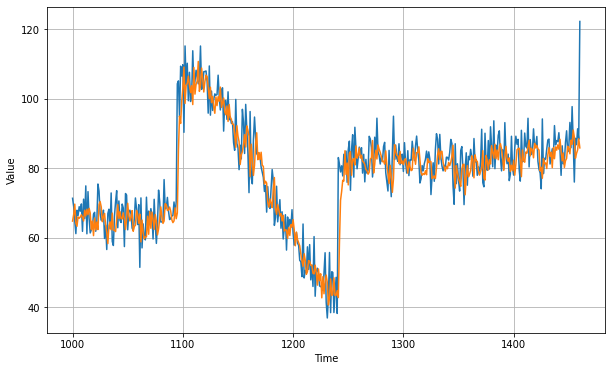

In [10]:
# Prediction

forecast = []

# Predict on entire sequence (train + validate)
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

# Only keep the validation data section of the sequence (after split time)
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

# plot with helper function
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [11]:
# goodness of fit: Mean Absolute Error
# different generations of the sequence will have different noise -> different MAE
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.0740514